This notebook motivated by how in March, there is a sudden increase in bad chirps (output from A11 winter below, generated using `clipping.ipynb`. 
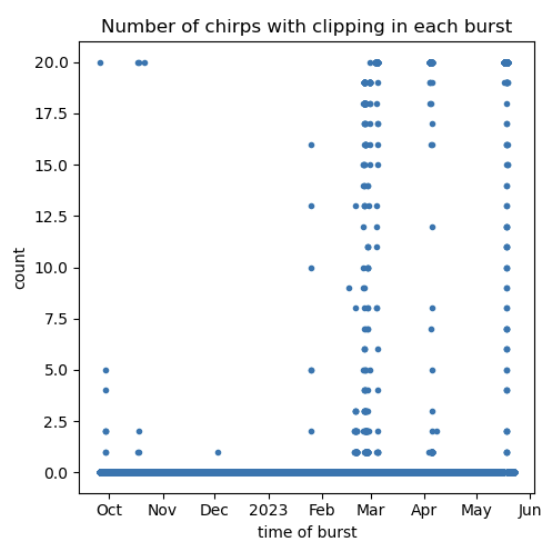

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    18:14:50 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    18:14:50 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    18:14:50 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37283")
client

<Client: 'tcp://127.0.0.1:37283' processes=4 threads=16, memory=125.81 GiB>

In [12]:
snippet = ds_101_w.isel(attenuator_setting_pair = 0,time=range(12000,18000))

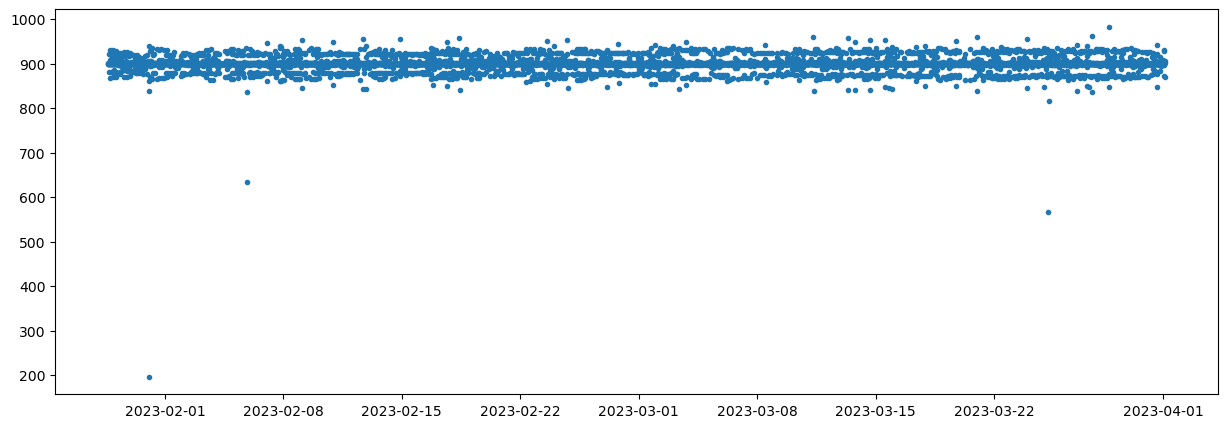

In [13]:
# Check sampling frequency
fig, ax = plt.subplots(figsize=(15,5))
diffs = snippet.time.diff(dim='time').values.astype('float64')/1e9
ax.plot(snippet.time.values[0:-1], diffs,linestyle='None',marker='.')

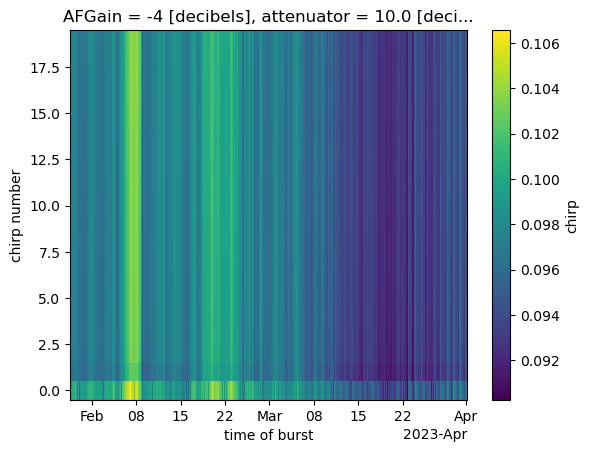

In [14]:
np.abs(snippet.chirp).mean(dim='chirp_time').plot(x='time')

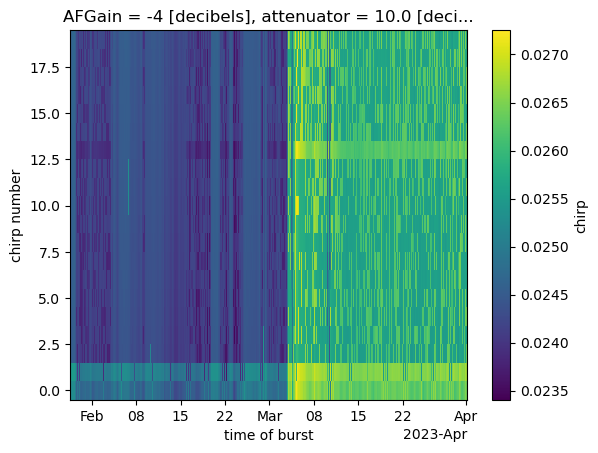

In [15]:
snippet.chirp.mean(dim='chirp_time').plot(x='time')

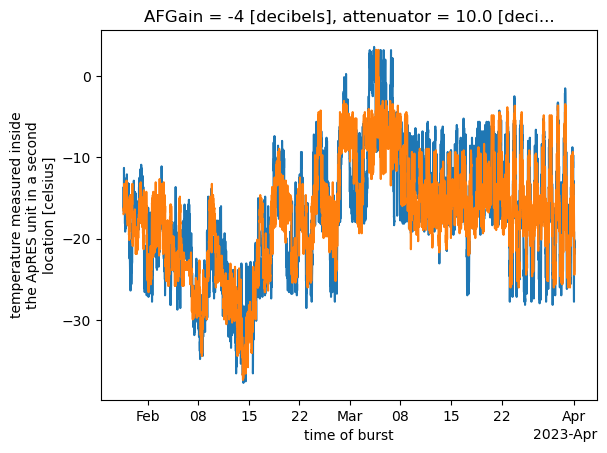

In [19]:
true_temp1 = snippet.temperature_1.where(lambda x: x<300, snippet.temperature_1-512)
true_temp2 = snippet.temperature_2.where(lambda x: x<300, snippet.temperature_2-512)

true_temp1.plot()
true_temp2.plot()

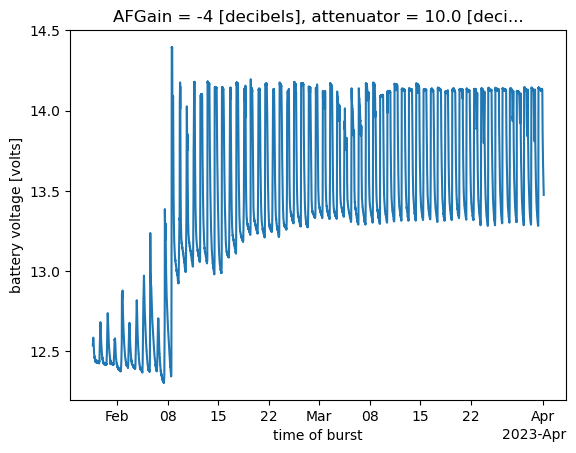

In [21]:
snippet.battery_voltage.plot()